In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

from models.mlp import BlackBoxModel
from models.rbf import RBFNet
from models.svm import LinearSVM
from utils.datasets import dataset_loader

pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

In [100]:
def bold(string):
    return "\033[1m" + string + "\033[0m"

In [101]:
name = 'compas'
dropped_features = []#UCIDatasets().continuous_features[dataset]
dataset = dataset_loader(name, dropped_features=dropped_features, n_bins=None)

In [102]:
dataset.data

,Sex = Female,Sex = Male,Age_Cat = Less than 25,Age_Cat = 25 - 45,Age_Cat = Greater than 45,Race = African-American,Race = Asian,Race = Caucasian,Race = Hispanic,Race = Native American,Race = Other,C_Charge_Degree = F,C_Charge_Degree = M,Priors_Count,Time_Served,Status
0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1
1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,10,0
2,0,1,1,0,0,1,0,0,0,0,0,1,0,4,1,0
3,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,1
4,0,1,0,1,0,0,0,1,0,0,0,1,0,14,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,1
6168,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,1
6169,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,1
6170,1,0,0,1,0,1,0,0,0,0,0,0,1,3,1,1


In [103]:
X_train, y_train, X_test, y_test, mean, std = dataset.get_split(normalise=False, shuffle=False,
                                                                     return_mean_std=True)
prop1s = round(np.average(y_train)*100, 2)
print(bold("Proportion of 1s in Training Data:") + " {}%".format(prop1s))

Proportion of 1s in Training Data: 54.53%


In [104]:
X = pd.DataFrame(X_train)
X.columns = dataset.features[:-1]
X_train = pd.DataFrame(X_train)
X_train.columns = dataset.features[:-1]
X_test = pd.DataFrame(X_test)
X_test.columns = dataset.features[:-1]
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
print(bold("Dataset:") + " {}\n".format(name.replace('_', ' ').title()))
X

Dataset: Compas



,Sex = Female,Sex = Male,Age_Cat = Less than 25,Age_Cat = 25 - 45,Age_Cat = Greater than 45,Race = African-American,Race = Asian,Race = Caucasian,Race = Hispanic,Race = Native American,Race = Other,C_Charge_Degree = F,C_Charge_Degree = M,Priors_Count,Time_Served
0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0
1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,10
2,0,1,1,0,0,1,0,0,0,0,0,1,0,4,1
3,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1
4,0,1,0,1,0,0,0,1,0,0,0,1,0,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4932,0,1,0,1,0,1,0,0,0,0,0,1,0,7,58
4933,0,1,0,1,0,0,0,1,0,0,0,1,0,7,43
4934,0,1,1,0,0,0,0,1,0,0,0,1,0,1,11
4935,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0


In [105]:
# B_name = 'dnn'  # 'lr' or 'dnn' or 'xgb'
# if B_name == 'dnn':
#     from models.models_global_ce import dnn_normalisers as normalisers
# elif B_name == 'lr':
#     from models.models_global_ce import lr_normalisers as normalisers
# else:  # no xgb normalisation
#     normalisers = {name: False}
# normalise = [mean, std] if normalisers[name] else None

In [106]:
# import pickle
# with open('data/models_global_ce/{}_{}.pkl'.format(name, B_name), 'rb') as f:
#     B = pickle.load(f)

In [107]:
# print(bold("Dataset:") + " {}".format(name.replace('_', ' ').title()))
# print(bold("Model:") + " {}\n".format(B_name.replace('_', ' ').upper()))
# performance(B, x_train, x_test, y_train, y_test, normalise=normalise)

In [108]:
target_name = 'Status'

In [109]:
seed = 42

np.random.seed(seed)  # for reproducibility


std = X_train.std()
mean = X_train.mean()

for col in ['Priors_Count', 'Time_Served']:
    X_train[col] = (X_train[col] - X_train[col].mean()) / X_train[col].std()
    X_test[col] = (X_test[col] - X_test[col].mean()) / X_test[col].std()

X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# Initialize the model, loss function, and optimizer
# model = BlackBoxModel(input_dim=X_train.shape[1])
# model = RBFNet(input_dim=X_train.shape[1], hidden_dim=X_train.shape[1])
model = LinearSVM(input_dim=X_train.shape[1])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

    # Convert outputs to binary using 0.5 as threshold
    y_pred_tensor = (test_outputs > 0.5).float()
    correct_predictions = (y_pred_tensor == y_test_tensor).float().sum()
    accuracy = correct_predictions / y_test_tensor.shape[0]

accuracy.item()

0.6469635367393494

In [110]:
sample_num = 100
X_test = pd.DataFrame(X_test, columns=X.columns)
# indice = (X_test.sample(sample_num)).index

# Fixing the indice for test purpose
indice = pd.Int64Index([ 753,  582,  548,  113,  174,  420,  309,  998,  413, 1054, 1171,
             275,  771, 1135,  415,  478,  609,  168,  332,  933,  490,  906,
            1073,  128,  107, 1136,   43, 1168,  327,  610,  596,  631, 1205,
             534,  597,  220,  911,  198,  743,  985,  231,  865, 1088,  715,
             306,  101,  438,   78, 1223,   49,  936,  736,  243,  868, 1096,
             937,  381,  767,   63,  323,   44,  943, 1098,  482,  575,  254,
             529,  286,  992,  123,   76,  218, 1110,  545,  292,  701, 1226,
             844,  363,  811,  754,  266,  904,  958,  590, 1222,  233,   70,
             566,   23,  155,  707,   58,  428, 1008, 1057,  342,  629,   81,
            1127],
           dtype='int64')


df_explain = X_test.loc[indice]

# y_target = torch.distributions.beta.Beta(0.1, 0.9).sample((sample_num,))
y_test = pd.Series(y_test.reshape(-1))
y_true = y_test.loc[indice]

y = model(torch.FloatTensor(df_explain.values))

C:\Users\leiyo\AppData\Local\Temp\ipykernel_35752\2639269771.py:5: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  indice = pd.Int64Index([ 753,  582,  548,  113,  174,  420,  309,  998,  413, 1054, 1171,


In [111]:
def postprocessing(counterfactual_X):

    prior_count_col = counterfactual_X['Priors_Count']
    time_served_col = counterfactual_X['Time_Served']
    counterfactual_X = (counterfactual_X>0.5).replace({False:0 ,True:1})
    counterfactual_X['Priors_Count'] = prior_count_col
    counterfactual_X['Time_Served'] = time_served_col
    
    return counterfactual_X

## GLOBE_CE

In [112]:
from explainers.globe_ce import GLOBE_CE

In [113]:
normalise = None

# AReS initiated to determine bin widths for costs
from explainers.ares import AReS
ares = AReS(model=model, dataset=dataset, X=dataset.data.drop(target_name,axis=1), n_bins=10, normalise=normalise)  # 1MB
bin_widths = ares.bin_widths

In [114]:
# example of ordinal features usage
ordinal_features = ['Present-Employment'] if name == 'german_credit' else []
# initialise GLOBE_CE
globe_ce = GLOBE_CE(model=model, dataset=dataset, X=df_explain, affected_subgroup=None,
                    dropped_features=dropped_features, ordinal_features=ordinal_features, delta_init='zeros',
                    normalise=normalise, bin_widths=bin_widths, monotonicity=None, p=1)

100%|██████████| 100/100 [00:00<00:00, 3036.62it/s]


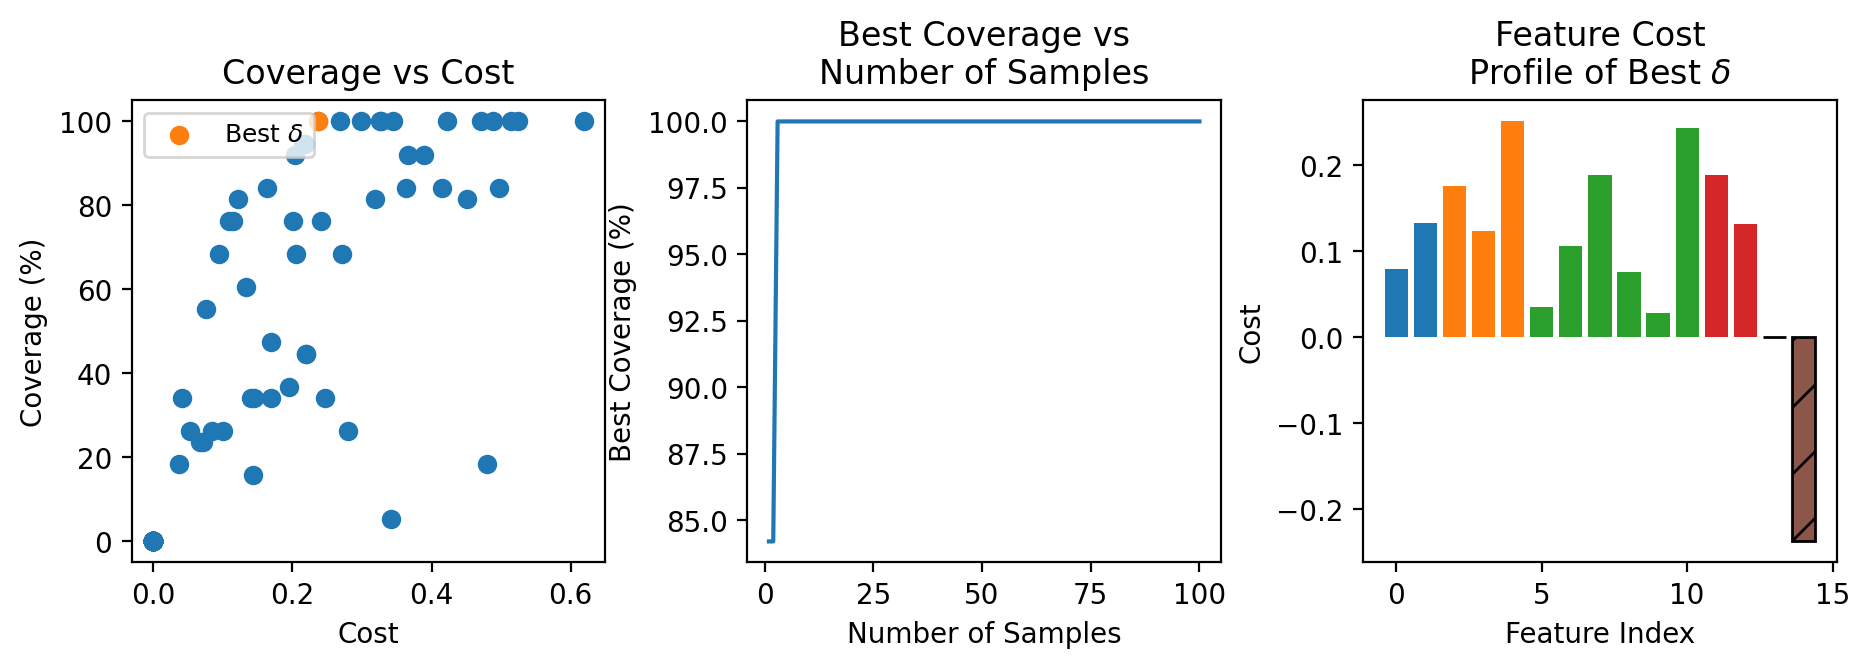

In [115]:
globe_ce.sample(n_sample=sample_num, magnitude=2, sparsity_power=1,  # magnitude is the fixed cost sampled at
                idxs=None, n_features=5, disable_tqdm=False,  # 2 random features chosen at each sample, no sparsity smoothing (p=1)
                plot=True, seed=0, scheme='random', dropped_features=dropped_features)
delta = globe_ce.best_delta  # pick best delta
globe_ce.select_n_deltas(n_div=3)

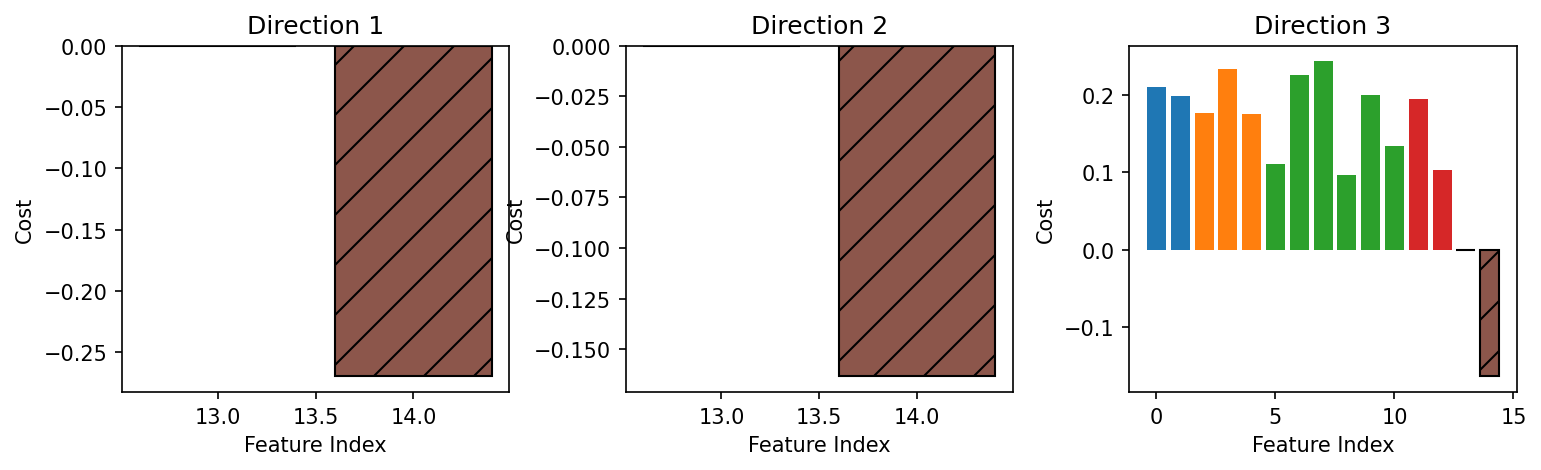

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=globe_ce.deltas_div.shape[0], dpi=150)
fig.set_figwidth(12)
fig.set_figheight(3)
plt.subplots_adjust(wspace=0.3)
for i in range(globe_ce.deltas_div.shape[0]):
    delta_cost = globe_ce.deltas_div[i] * globe_ce.feature_costs_vector
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    j, k = 0, 0
    for feature in globe_ce.features_tree:
        if not globe_ce.features_tree[feature]:
            ax[i].bar(range(j, j+1), delta_cost[j], hatch='/',
                        linewidth=1, edgecolor='black', color=cycle[k%len(cycle)])
            j += 1
            k += 1
        else:
            feature_values = globe_ce.features_tree[feature]
            n_f = len(feature_values)
            ax[2].bar(range(j, j+n_f), delta_cost[j:j+n_f], color=cycle[k%len(cycle)])
            j += n_f
            k += 1
    ax[i].set_title(f'Direction {i+1}')
    ax[i].set_xlabel('Feature Index')
    ax[i].set_ylabel('Cost')
plt.show()

In [117]:
n_div = globe_ce.deltas_div.shape[0]
min_costs = np.zeros((n_div, globe_ce.x_aff.shape[0]))
min_costs_idxs = np.zeros((n_div, globe_ce.x_aff.shape[0]))
for i in range(n_div):  # Algorithm 1, Line 2
    cor_s, cos_s, k_s = globe_ce.scale(globe_ce.deltas_div[i], disable_tqdm=False, vector=True)  # Algorithm 1, Line 3
    min_costs[i], min_costs_idxs[i] = globe_ce.min_scalar_costs(cos_s, return_idxs=True, inf=True)  # Implicitly computes Algorithm 1, Lines 4-6, returning minimum costs per input and their indices in the k vector
    max_scalar_idxs = globe_ce.cluster_by_costs(cos_s, n_bins=5)
min_costs = min_costs.min(axis=0)

100%|██████████| 1000/1000 [00:00<00:00, 5102.96it/s]


Unable to find recourse for 0/38 inputs


100%|██████████| 1000/1000 [00:00<00:00, 5023.36it/s]


Unable to find recourse for 0/38 inputs


100%|██████████| 1000/1000 [00:00<00:00, 5018.15it/s]

Unable to find recourse for 0/38 inputs


In [118]:
ces = globe_ce.round_categorical(globe_ce.x_aff+globe_ce.best_delta) if globe_ce.n_categorical else globe_ce.x_aff+globe_ce.best_delta
counterfactual_X_global_ce = pd.DataFrame(ces, columns=X_test.columns)
counterfactual_X_global_ce = postprocessing(counterfactual_X_global_ce)
counterfactual_y_global_ce = model.predict(counterfactual_X_global_ce.values)

In [119]:
print('Coverage (Globe CE):', counterfactual_y_global_ce.sum()/len(counterfactual_y_global_ce))

Coverage (Globe CE): 1.0


In [120]:
factual_X = pd.DataFrame(globe_ce.x_aff, columns=df_explain.columns)
factual_y = model.predict(factual_X.values)

In [121]:
y_target = torch.ones(factual_X.shape[0])

In [122]:
costs_vector = globe_ce.feature_costs_vector

## AReS

In [171]:
# AReS initiated to determine bin widths for costs
from explainers.ares import AReS
ares = AReS(model=model, dataset=dataset, X=factual_X, n_bins=10, normalise=normalise)  # 1MB

C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 15 combinations | Sampling itemset size 54
SD and RL Computed with Lengths 58 and 58
Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 58 to 37


100%|██████████| 58/58 [00:00<00:00, 7084.97it/s]


Ground Set Computed with Length 710


199it [00:00, 541.85it/s]


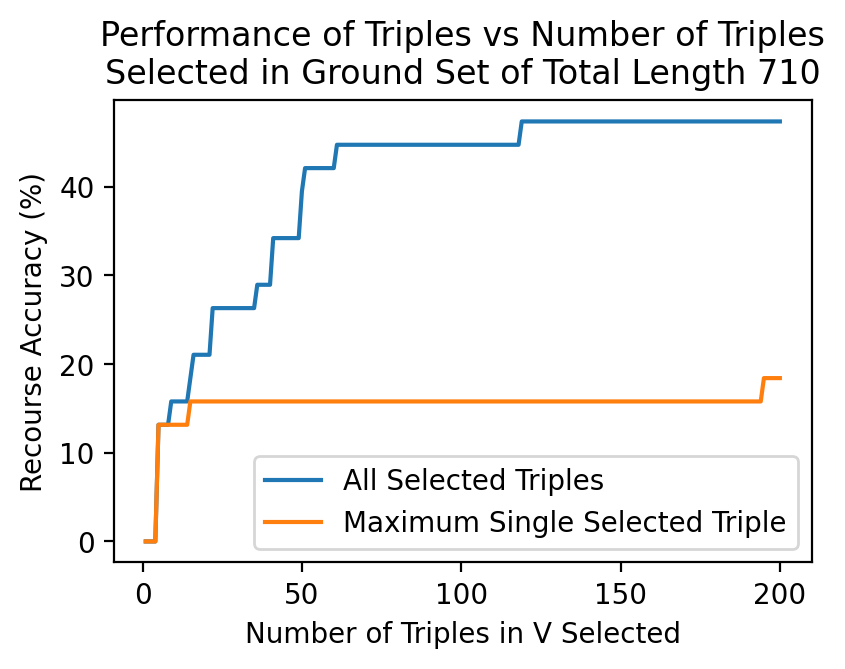

Candidate Set Filtered with Length: 200
Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 199/199 [00:00<00:00, 12709.04it/s]


Checking Exchange


100%|██████████| 194/194 [00:00<00:00, 2295.29it/s]


Checking Delete
Checking Add


100%|██████████| 194/194 [00:00<00:00, 14369.38it/s]
5it [00:00, 390.07it/s]


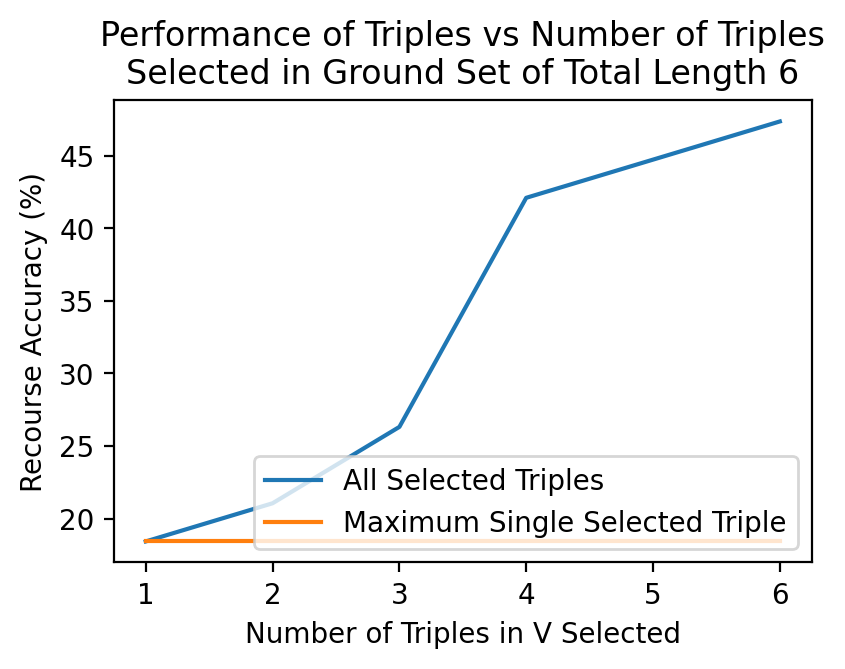

In [173]:
ares.generate_itemsets(apriori_threshold=0.2, max_width=None, # defaults to e2-1
                       affected_subgroup=None, save_copy=False)
# Note: progress bar initial time estimate about 10 times too large
ares.generate_groundset(max_width=None, RL_reduction=True,
                        then_generation=None, save_copy=False)
lams = [1, 0]  # can play around with these lambda values
ares.evaluate_groundset(lams=lams, r=200, save_mode=1,
                        disable_tqdm=False, plot_accuracy=True)
ares.select_groundset(s=200)
ares.optimise_groundset(lams=lams, factor=1, print_updates=False,
                        print_terms=False)

In [169]:
counterfactual_X_ares = pd.DataFrame(ares.R.cfx_matrix[0], columns=X_test.columns)
counterfactual_X_ares = postprocessing(counterfactual_X_ares)
counterfactual_y_ares = model.predict(counterfactual_X_ares.values)

In [170]:
print('Coverage (AReS):', counterfactual_y_ares.sum()/len(counterfactual_y_ares))

Coverage (AReS): 0.05263157894736842


## Diverse Counterfactual Explanation (DiCE)

In [127]:
backend = 'PYT'  # needs pytorch installed

In [128]:
import dice_ml

m = dice_ml.Model(model=model, backend='PYT')

factual_X_ext = factual_X.copy()
factual_X_ext[target_name] = factual_y

dice_features = factual_X.columns.drop(['Race = Asian', 'Race = Other']).to_list()

d = dice_ml.Data(dataframe=factual_X_ext, continuous_features=dice_features, outcome_name = target_name)

dice_explainer = dice_ml.Dice(d, m, method="gradient")

In [129]:
# import os 
# import pickle 
# dump_data_path = './data/baseline/'
# with open(os.path.join(dump_data_path, f"dice_results_{model.name}_{name}.pkl"), 'rb') as file:
#     dice_results = pickle.load(file)

In [130]:
dice_results = dice_explainer.generate_counterfactuals(query_instances=factual_X, features_to_vary=dice_features, desired_class="opposite", total_CFs=1)

  3%|▎         | 1/38 [00:09<05:45,  9.33s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 09 sec


  5%|▌         | 2/38 [00:10<02:39,  4.43s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 00 sec


  8%|▊         | 3/38 [00:11<01:40,  2.88s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 00 sec


 11%|█         | 4/38 [00:21<03:17,  5.81s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 10 sec


 13%|█▎        | 5/38 [00:31<03:57,  7.19s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 09 sec


 16%|█▌        | 6/38 [00:52<06:22, 11.95s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 09 sec


 18%|█▊        | 7/38 [01:15<08:01, 15.54s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 09 sec


 21%|██        | 8/38 [01:39<09:08, 18.30s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 11 sec


 24%|██▎       | 9/38 [01:50<07:42, 15.93s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 10 sec


 26%|██▋       | 10/38 [02:15<08:43, 18.69s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 12 sec


 29%|██▉       | 11/38 [02:38<08:59, 19.97s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 09 sec


 32%|███▏      | 12/38 [03:04<09:30, 21.93s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 12 sec


 34%|███▍      | 13/38 [03:31<09:45, 23.40s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 12 sec


 37%|███▋      | 14/38 [03:32<06:40, 16.70s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 01 sec


 39%|███▉      | 15/38 [03:59<07:36, 19.83s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 11 sec


 42%|████▏     | 16/38 [04:14<06:41, 18.27s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 14 sec


 45%|████▍     | 17/38 [04:36<06:46, 19.38s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 10 sec


 47%|████▋     | 18/38 [04:57<06:38, 19.91s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 09 sec


 50%|█████     | 19/38 [05:09<05:36, 17.71s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 01 sec


 53%|█████▎    | 20/38 [05:11<03:49, 12.74s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 01 sec


 55%|█████▌    | 21/38 [05:18<03:09, 11.12s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 07 sec


 58%|█████▊    | 22/38 [05:39<03:44, 14.04s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 09 sec


 61%|██████    | 23/38 [05:50<03:20, 13.33s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 11 sec


 63%|██████▎   | 24/38 [05:59<02:45, 11.80s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 08 sec


 66%|██████▌   | 25/38 [06:01<01:54,  8.84s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 01 sec


 68%|██████▊   | 26/38 [06:02<01:19,  6.65s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 01 sec


 71%|███████   | 27/38 [06:23<02:00, 11.00s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 09 sec


 74%|███████▎  | 28/38 [06:44<02:20, 14.05s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 09 sec


 76%|███████▋  | 29/38 [07:14<02:48, 18.76s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 13 sec


 79%|███████▉  | 30/38 [07:25<02:10, 16.26s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 10 sec


 82%|████████▏ | 31/38 [07:37<01:45, 15.13s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 12 sec


 84%|████████▍ | 32/38 [07:50<01:26, 14.43s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 12 sec


 87%|████████▋ | 33/38 [08:19<01:34, 18.85s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 13 sec


 89%|████████▉ | 34/38 [08:52<01:31, 22.93s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 16 sec


 92%|█████████▏| 35/38 [09:06<01:01, 20.48s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 14 sec


 95%|█████████▍| 36/38 [09:39<00:48, 24.19s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 15 sec


 97%|█████████▋| 37/38 [10:08<00:25, 25.52s/it]WARNING:root: MAD for feature Sex = Female is 0, so replacing it with 1.0 to avoid error.


Diverse Counterfactuals found! total time taken: 00 min 13 sec


100%|██████████| 38/38 [10:33<00:00, 16.66s/it]

Diverse Counterfactuals found! total time taken: 00 min 11 sec


In [131]:
# Iterate through each result and append to the DataFrame
dice_df_list = []
for cf in dice_results.cf_examples_list:
    # Convert to DataFrame and append
    cf_df = cf.final_cfs_df
    dice_df_list.append(cf_df)

counterfactual_X_dice = pd.concat(dice_df_list).reset_index(drop=True).drop(target_name, axis=1)
counterfactual_X_dice = postprocessing(counterfactual_X_dice)

In [132]:
counterfactual_y_dice = model.predict(counterfactual_X_dice.values)

In [133]:
print('Coverage (DiCE):', counterfactual_y_dice.sum()/len(counterfactual_y_dice))

Coverage (DiCE): 0.9736842105263158


In [134]:
# import os 
# import pickle 
# dump_data_path = './data/baseline/'
# with open(os.path.join(dump_data_path, f"dice_results_{model.name}_{name}.pkl"), "wb") as file:
#     pickle.dump(dice_results, file)

## Distributional Counterfactual Explanation (DCE)

In [135]:
from explainers.dce import DistributionalCounterfactualExplainer

delta = 1e-5
alpha = 0.05
N = 10

explain_columns = df_explain.columns

explainer = DistributionalCounterfactualExplainer(
    model=model, 
    df_X=factual_X, 
    explain_columns=explain_columns,
    y_target=y_target, 
    lr=0.1, 
    n_proj=N,
    delta=delta,
    costs_vector=None)

In [136]:
# import os 
# import pickle 
# dump_data_path = './data/baseline/'
# with open(os.path.join(dump_data_path, f"explainer_{model.name}_{name}.pkl"), 'rb') as file:
#     explainer = pickle.load(file)

In [137]:
explainer.optimize(U_1=0.01, U_2=0.2, l=0.7, r=0.85, max_iter=100, tau=1e3)

INFO:root:Optimization started
INFO:root:U_1-Qu_upper=0.01, U_2-Qv_upper=-0.5213172399913655
INFO:root:eta=0.85, l=0.7074999999999999, r=0.85
INFO:root:Iter 1: Q = 0.06727836281061172, term1 = 0.028706947341561317, term2 = 0.07408507913351059
INFO:root:U_1-Qu_upper=-0.19590402405833027, U_2-Qv_upper=-0.1057310271720987
INFO:root:eta=0.7574500018667065, l=0.7074999999999999, r=0.8428749999999999
INFO:root:Iter 2: Q = 0.04856676235795021, term1 = 0.009947082959115505, term2 = 0.06093352288007736
INFO:root:U_1-Qu_upper=-0.1024911347031009, U_2-Qv_upper=-0.06578876078974721
INFO:root:eta=0.760424643587567, l=0.7074999999999999, r=0.8361062499999999
INFO:root:Iter 3: Q = 0.027111202478408813, term1 = 0.007836738601326942, term2 = 0.033183712512254715
INFO:root:U_1-Qu_upper=-0.0856211654983721, U_2-Qv_upper=0.008300876374542798
INFO:root:eta=0.7074999999999999, l=0.7074999999999999, r=0.8296759374999999
INFO:root:Iter 4: Q = 0.02003321424126625, term1 = 0.0034189000725746155, term2 = 0.02690

In [138]:
# import os 
# import pickle 
# dump_data_path = './data/baseline/'
# with open(os.path.join(dump_data_path, f"explainer_{model.name}_{name}.pkl"), "wb") as file:
#     pickle.dump(explainer, file)

In [139]:
X_train = pd.DataFrame(X_train, columns=X.columns)

In [140]:
counterfactual_X_dce = pd.DataFrame(explainer.best_X.detach().numpy(), columns=df_explain.columns)
counterfactual_X_dce = postprocessing(counterfactual_X_dce)

dtype_dict = X_train.dtypes.apply(lambda x: x.name).to_dict()
for k, v in dtype_dict.items():
    if k in counterfactual_X_dce.columns:
        if v[:3] == 'int':
            counterfactual_X_dce[k] = counterfactual_X_dce[k].round().astype(v)
        else:
            counterfactual_X_dce[k] = counterfactual_X_dce[k].astype(v)

counterfactual_y_prob_dce = pd.DataFrame(explainer.y.detach().numpy(),columns=[target_name], index=counterfactual_X_dce.index)
counterfactual_y_dce = np.int64((counterfactual_y_prob_dce.values > 0.5).reshape(-1))

In [141]:
print('Coverage (DCE):', counterfactual_y_dce.sum()/len(counterfactual_y_dce))

Coverage (DCE): 0.9736842105263158


## Distance Evaluation

In [142]:
from explainers.distances import SlicedWassersteinDivergence, WassersteinDivergence
from scipy.stats import gaussian_kde, entropy
from numpy.linalg import LinAlgError

def compute_distance(X_s, X_t):
    if type(X_s) == pd.DataFrame:
        X_s = torch.FloatTensor(X_s.values)
    if type(X_t) == pd.DataFrame:
        X_t = torch.FloatTensor(X_t.values)

    if type(X_s) == np.ndarray:
        X_s = torch.FloatTensor(X_s)
    if type(X_t) == np.ndarray:
        X_t = torch.FloatTensor(X_t)

    if X_s.ndim == 1:
        wd = WassersteinDivergence()
        distance, _ = wd.distance(X_s, X_t, delta=0.1)
    else:
        swd = SlicedWassersteinDivergence(
                dim=X_s.shape[1], n_proj=5000
        )
        distance, _ = swd.distance(X_s, X_t, delta=0.1)
    return distance.item()


def compute_kl_divergence(X_s, X_t):
    kl_divergences = []
    for i in range(X_s.shape[1]):  # Iterate over columns (features)
        try:
            # Estimate probability distributions using KDE
            kde_s = gaussian_kde(X_s[:, i])
            kde_t = gaussian_kde(X_t[:, i])

            # Evaluate the densities on a linear space of the same range
            x_min = min(X_s[:, i].min(), X_t[:, i].min())
            x_max = max(X_s[:, i].max(), X_t[:, i].max())
            x = np.linspace(x_min, x_max, 1000)

            # Compute the KL divergence (entropy)
            kl_div = entropy(kde_s(x), kde_t(x))
        except LinAlgError:
            # Catch the singular matrix error and set the divergence to infinity
            kl_div = np.inf

        kl_divergences.append(kl_div)

    # Aggregate the KL divergences
    total_kl_divergence = np.sum(kl_divergences)  # Or use np.mean for average
    return total_kl_divergence

def gaussian_kernel(x, y, sigma=1.0):
    """Compute the Gaussian kernel between x and y"""
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

def mmd(X_s, X_t, kernel=gaussian_kernel):
    """Compute the Maximum Mean Discrepancy (MMD) between two samples X_s and X_t"""
    n = X_s.shape[0]
    m = X_t.shape[0]

    # Calculate the kernel values between all points in the first sample
    XX = np.sum([kernel(X_s[i], X_s[j]) for i in range(n) for j in range(n)])
    
    # Calculate the kernel values between all points in the second sample
    YY = np.sum([kernel(X_t[i], X_t[j]) for i in range(m) for j in range(m)])
    
    # Calculate the kernel values between all points across the two samples
    XY = np.sum([kernel(X_s[i], X_t[j]) for i in range(n) for j in range(m)])

    return XX / (n ** 2) + YY / (m ** 2) - 2 * XY / (n * m)


In [143]:
cov_ares = counterfactual_y_ares.sum()/len(counterfactual_y_ares)
cov_global_ce = counterfactual_y_global_ce.sum()/len(counterfactual_y_global_ce)
cov_dice = counterfactual_y_dice.sum()/len(counterfactual_y_dice)
cov_dce = counterfactual_y_dce.sum()/len(counterfactual_y_dce)

In [144]:
print('Coverage (AReS):', cov_ares)
print('Coverage (Globe CE):', cov_global_ce)
print('Coverage (DiCE):', cov_dice)
print('Coverage (DCE):', cov_dce)

Coverage (AReS): 0.18421052631578946
Coverage (Globe CE): 1.0
Coverage (DiCE): 0.9736842105263158
Coverage (DCE): 0.9736842105263158


In [145]:
ot_dist_ares = compute_distance(X_s=counterfactual_X_ares, X_t=factual_X)
ot_dist_global_ce = compute_distance(X_s=counterfactual_X_global_ce, X_t=factual_X)
ot_dist_dce = compute_distance(X_s=counterfactual_X_dce, X_t=factual_X)
ot_dist_dice = compute_distance(X_s=counterfactual_X_dice.dropna(), X_t=factual_X)


print('X Distance (AReS):', ot_dist_ares)
print('X Distance (Globe CE):', ot_dist_global_ce)
print('X Distance (DiCE):', ot_dist_dice)
print('X Distance (DCE):', ot_dist_dce)

X Distance (AReS): 0.015320036560297012
X Distance (Globe CE): 30.745779037475586
X Distance (DiCE): 0.22971652448177338
X Distance (DCE): 0.14119158685207367


In [146]:
print('X MMD (AReS):', mmd(X_s=counterfactual_X_ares.values, X_t=factual_X.values))
print('X MMD (Globe CE):', mmd(X_s=counterfactual_X_global_ce.values, X_t=factual_X.values))
print('X MMD (DiCE):', mmd(X_s=counterfactual_X_dice.dropna().values, X_t=factual_X.values))
print('X MMD (DCE):', mmd(X_s=counterfactual_X_dce.values, X_t=factual_X.values))

X MMD (AReS): 0.019386470244398768
X MMD (Globe CE): 0.22600758517656552
X MMD (DiCE): 0.22796638545693007
X MMD (DCE): 0.1056852255284602


In [147]:
print('X KL-Divergence (AReS):', 
      compute_kl_divergence(X_s=counterfactual_X_ares.values, X_t=factual_X.values))
print('X KL-Divergence (Globe CE):', 
      compute_kl_divergence(X_s=counterfactual_X_global_ce.values, X_t=factual_X.values))
print('X KL-Divergence (DiCE):', 
      compute_kl_divergence(X_s=counterfactual_X_dice.dropna().values, X_t=factual_X.values))
print('X KL-Divergence (DCE):', 
      compute_kl_divergence(X_s=counterfactual_X_dce.values, X_t=factual_X.values))

X KL-Divergence (AReS): inf
X KL-Divergence (Globe CE): inf
X KL-Divergence (DiCE): inf
X KL-Divergence (DCE): inf


In [148]:
ares_diff_pct = []
globe_ce_diff_pct = []
dice_diff_pct = []
dce_diff_pct = []
for column in df_explain.columns:
    ares_pct = (counterfactual_X_ares[column] - factual_X[column]).abs().sum() / (1e-7 + factual_X[column].abs().sum())
    globe_ce_pct = (counterfactual_X_global_ce[column] - factual_X[column]).abs().sum() / (1e-7 + factual_X[column].abs().sum())
    dice_pct = (counterfactual_X_dice[column] - factual_X[column]).abs().sum() / (1e-7 + factual_X[column].abs().sum())
    dce_pct = (counterfactual_X_dce[column] - factual_X[column]).abs().sum() / (1e-7 + factual_X[column].abs().sum())

    ares_diff_pct.append({column: ares_pct})
    globe_ce_diff_pct.append({column: globe_ce_pct})
    dice_diff_pct.append({column: dice_pct})
    dce_diff_pct.append({column: dce_pct})

## Cost Evaluation

In [149]:
def compute_cost(delta, costs_vector):
    return np.linalg.norm(delta @ np.diag(costs_vector)) 


def compute_absolute_difference(counterfactual_X, factual_X):
    columns = counterfactual_X.columns.drop(['Priors_Count', 'Time_Served'])
    diff_list = []

    for column in columns:
        diff_list.append((counterfactual_X[column] - factual_X[column]).abs().mean())

    return np.nanmean(diff_list)

def compute_statistic_difference(counterfactual_X, factual_X, metric, columns):
    diff_list = []
    for column in columns:
        val_cf = counterfactual_X[column].agg(metric)
        val_f = factual_X[column].agg(metric)
        diff_list.append(abs(val_cf - val_f)/(abs(val_f)) * 100)

    return np.nanmean(diff_list)


In [150]:
ares_delta = (counterfactual_X_ares - factual_X).dropna().values
globe_ce_delta = (counterfactual_X_global_ce - factual_X).values
dce_delta = (counterfactual_X_dce - factual_X).dropna().values
dice_delta = (counterfactual_X_dice - factual_X).dropna().values
# dice_delta = (counterfactual_X_dice.dropna() - factual_X.loc[counterfactual_X_dice.dropna().index]).values

In [151]:
print('Cost (AReS):', compute_cost(ares_delta, costs_vector))
print('Cost (Globe CE):', compute_cost(globe_ce_delta, costs_vector))
print('Cost (DiCE):', compute_cost(dice_delta, costs_vector))
print('Cost (DCE):', compute_cost(dce_delta, costs_vector))

Cost (AReS): 2.0
Cost (Globe CE): 1.4643549521044608
Cost (DiCE): 5.004487171096834
Cost (DCE): 4.757899157346214


In [152]:
print('Categorical Difference (AReS):', compute_absolute_difference(counterfactual_X_ares, factual_X))
print('Categorical Difference (Globe CE):', compute_absolute_difference(counterfactual_X_global_ce, factual_X))
print('Categorical Difference (DiCE):', compute_absolute_difference(counterfactual_X_dice.dropna(), factual_X))
print('Categorical Difference (DCE):', compute_absolute_difference(counterfactual_X_dce, factual_X))

Categorical Difference (AReS): 0.032388663967611336
Categorical Difference (Globe CE): 0.0
Categorical Difference (DiCE): 0.17206477732793524
Categorical Difference (DCE): 0.17611336032388666


In [153]:
metric = 'mean'
columns = ['Priors_Count'] # , 'Time_Served'
print(f'Difference {metric} (AReS):', compute_statistic_difference(counterfactual_X_ares, factual_X, metric,columns))
print(f'Difference {metric} (Globe CE):', compute_statistic_difference(counterfactual_X_global_ce, factual_X, metric,columns))
print(f'Difference {metric} (DiCE):', compute_statistic_difference(counterfactual_X_dice, factual_X, metric,columns))
print(f'Difference {metric} (DCE):', compute_statistic_difference(counterfactual_X_dce, factual_X, metric,columns))

Difference mean (AReS): 0.0
Difference mean (Globe CE): 0.0
Difference mean (DiCE): 49.47977838926819
Difference mean (DCE): 53.800448435764245


In [154]:
metric = 'std'
columns = ['Priors_Count'] # , 'Time_Served'
print(f'Difference {metric} (AReS):', compute_statistic_difference(counterfactual_X_ares, factual_X, metric,columns))
print(f'Difference {metric} (Globe CE):', compute_statistic_difference(counterfactual_X_global_ce, factual_X, metric,columns))
print(f'Difference {metric} (DiCE):', compute_statistic_difference(counterfactual_X_dice, factual_X, metric,columns))
print(f'Difference {metric} (DCE):', compute_statistic_difference(counterfactual_X_dce, factual_X, metric,columns))

Difference std (AReS): 0.0
Difference std (Globe CE): 0.0
Difference std (DiCE): 68.78658795200151
Difference std (DCE): 1.6493118603640504


In [155]:
metric = 'mean'
columns = ['Time_Served'] # , 'Time_Served'
print(f'Difference {metric} (AReS):', compute_statistic_difference(counterfactual_X_ares, factual_X, metric,columns))
print(f'Difference {metric} (Globe CE):', compute_statistic_difference(counterfactual_X_global_ce, factual_X, metric,columns))
print(f'Difference {metric} (DiCE):', compute_statistic_difference(counterfactual_X_dice, factual_X, metric,columns))
print(f'Difference {metric} (DCE):', compute_statistic_difference(counterfactual_X_dce, factual_X, metric,columns))

Difference mean (AReS): 0.0
Difference mean (Globe CE): 3704.342096287626
Difference mean (DiCE): 51.85124511644915
Difference mean (DCE): 53.35593976003034


In [156]:
metric = 'std'
columns = ['Time_Served'] # , 'Time_Served'
print(f'Difference {metric} (AReS):', compute_statistic_difference(counterfactual_X_ares, factual_X, metric,columns))
print(f'Difference {metric} (Globe CE):', compute_statistic_difference(counterfactual_X_global_ce, factual_X, metric,columns))
print(f'Difference {metric} (DiCE):', compute_statistic_difference(counterfactual_X_dice, factual_X, metric,columns))
print(f'Difference {metric} (DCE):', compute_statistic_difference(counterfactual_X_dce, factual_X, metric,columns))

Difference std (AReS): 0.0
Difference std (Globe CE): 0.0
Difference std (DiCE): 79.28489176349099
Difference std (DCE): 1.343959421630669


## Diversity

In [157]:
def compute_average_pairwise_distance(counterfactual_X):
    n = len(counterfactual_X)
    total_distance = 0
    count = 0

    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(counterfactual_X.iloc[i] - counterfactual_X.iloc[j])
            total_distance += dist
            count += 1

    if count > 0:
        average_distance = total_distance / count
    else:
        average_distance = 0

    return average_distance


In [158]:
diversity_factual = compute_average_pairwise_distance(factual_X)

In [159]:
print('Diversity (Factual)', diversity_factual)

Diversity (Factual) 3.3613747724778062


In [160]:
diversity_ares = compute_average_pairwise_distance(counterfactual_X_ares)
diversity_global_ce = compute_average_pairwise_distance(counterfactual_X_global_ce)
diversity_dice = compute_average_pairwise_distance(counterfactual_X_dice.dropna())
diversity_dce = compute_average_pairwise_distance(counterfactual_X_dce)

In [161]:
print('Diversity (AReS):', diversity_ares)
print('Diversity (Globe CE):', diversity_global_ce)
print('Diversity (DiCE):', diversity_dice)
print('Diversity (DCE):', diversity_dce)

Diversity (AReS): 3.2808134674587675
Diversity (Globe CE): 3.361374772477807
Diversity (DiCE): 2.011438216960557
Diversity (DCE): 3.4481292587826897


In [162]:
print('Effective Diversity (AReS):', diversity_ares/ot_dist_ares * cov_ares)
print('Effective Diversity (Globe CE):', diversity_global_ce/ot_dist_global_ce * cov_global_ce)
print('Effective Diversity (DiCE):', diversity_dice/ot_dist_dice * cov_dice)
print('Effective Diversity (DCE):', diversity_dce/ot_dist_dce * cov_dce)

Effective Diversity (AReS): 39.449016535035796
Effective Diversity (Globe CE): 0.10932800786672785
Effective Diversity (DiCE): 8.525749885525087
Effective Diversity (DCE): 23.778959426584304
